In [1]:
import time
import timeit
import os
import requests
import base64
from dotenv import load_dotenv
import json
from urllib.parse import urlencode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import random
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("data/spotify_data.csv", index_col=0)
df.head(10)

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.043,0.694,0.000,0.115,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.026,0.477,0.000,0.097,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.032,0.338,0.000,0.089,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.036,0.807,0.000,0.080,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.030,0.073,0.019,0.110,0.217,171.864,244320,4
5,Chris Smither,What They Say,24NvptbNKGs6sPy1Vh1O0v,48,2012,acoustic,0.566,0.570,2,-6.420,1,0.033,0.688,0.000,0.094,0.960,83.403,166240,4
6,Matt Wertz,Walking in a Winter Wonderland,0BP7hSvLAG3URGrEvNNbGM,48,2012,acoustic,0.575,0.606,9,-8.197,1,0.030,0.012,0.000,0.068,0.364,121.083,152307,4
7,Green River Ordinance,Dancing Shoes,3Y6BuzQCg9p4yH347Nn8OW,45,2012,acoustic,0.586,0.423,7,-7.459,1,0.026,0.252,0.000,0.098,0.318,138.133,232373,4
8,Jason Mraz,Living in the Moment,3ce7k1L4EkZppZPz1EJWTS,44,2012,acoustic,0.650,0.628,7,-7.160,1,0.023,0.048,0.000,0.119,0.700,84.141,235080,4
9,Boyce Avenue,Heaven,2EKxmYmUdAVXlaHCnnW13o,58,2012,acoustic,0.619,0.280,8,-10.238,0,0.032,0.730,0.000,0.103,0.292,129.948,250063,4


## Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1159764 entries, 0 to 1473395
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   artist_name       1159749 non-null  object 
 1   track_name        1159763 non-null  object 
 2   track_id          1159764 non-null  object 
 3   popularity        1159764 non-null  int64  
 4   year              1159764 non-null  int64  
 5   genre             1159764 non-null  object 
 6   danceability      1159764 non-null  float64
 7   energy            1159764 non-null  float64
 8   key               1159764 non-null  int64  
 9   loudness          1159764 non-null  float64
 10  mode              1159764 non-null  int64  
 11  speechiness       1159764 non-null  float64
 12  acousticness      1159764 non-null  float64
 13  instrumentalness  1159764 non-null  float64
 14  liveness          1159764 non-null  float64
 15  valence           1159764 non-null  float64
 16  tempo

In [4]:
df.describe()

,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000,1159764.000
mean,18.383,2011.955,0.537,0.640,5.288,-8.981,0.635,0.093,0.322,0.252,0.223,0.456,121.377,249561.781,3.886
std,15.886,6.804,0.184,0.271,3.555,5.682,0.482,0.127,0.355,0.365,0.201,0.269,29.780,149426.165,0.468
min,0.000,2000.000,0.000,0.000,0.000,-58.100,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2073.000,0.000
25%,5.000,2006.000,0.413,0.454,2.000,-10.829,0.000,0.037,0.006,0.000,0.098,0.226,98.797,181091.000,4.000
50%,15.000,2012.000,0.550,0.694,5.000,-7.450,1.000,0.051,0.147,0.002,0.134,0.438,121.931,225744.000,4.000
75%,29.000,2018.000,0.677,0.873,8.000,-5.276,1.000,0.089,0.640,0.614,0.292,0.674,139.903,286913.500,4.000
max,100.000,2023.000,0.993,1.000,11.000,6.172,1.000,0.971,0.996,1.000,1.000,1.000,249.993,6000495.000,5.000


In [5]:
df.isna().any()

artist_name          True
track_name           True
track_id            False
popularity          False
year                False
genre               False
danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
duration_ms         False
time_signature      False
dtype: bool

In [6]:
sum(df['artist_name'].isna())

15

In [7]:
sum(df['track_name'].isna())

1

(array([4.25164e+05, 2.57757e+05, 1.99251e+05, 1.44216e+05, 8.03860e+04,
        3.70400e+04, 1.25040e+04, 2.94700e+03, 4.71000e+02, 2.80000e+01]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

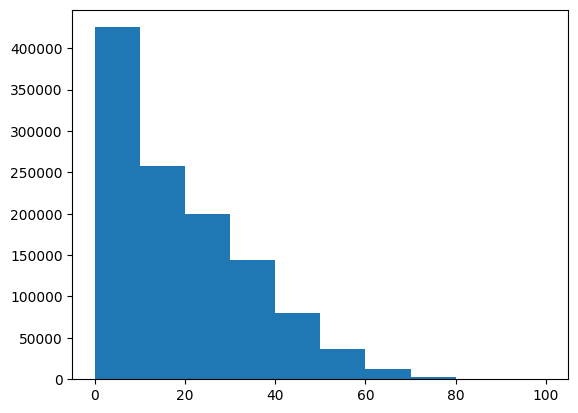

In [8]:
# track popularity (0 to 100)
plt.hist(df['popularity'])

(array([128487.,  85758.,  89254., 140302.,  93312., 108013., 145059.,
        112813., 110859., 145907.]),
 array([2000. , 2002.3, 2004.6, 2006.9, 2009.2, 2011.5, 2013.8, 2016.1,
        2018.4, 2020.7, 2023. ]),
 <BarContainer object of 10 artists>)

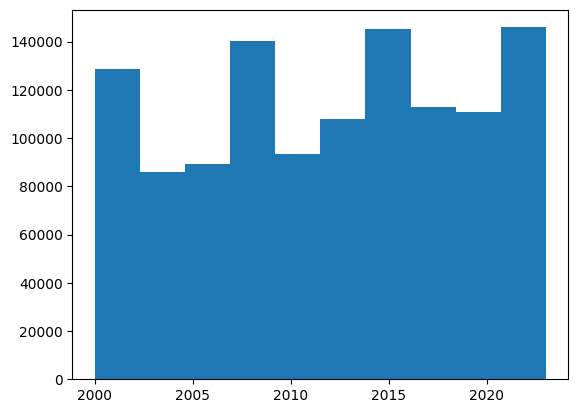

In [9]:
plt.hist(df['year'])

In [10]:
df['genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'ambient', 'black-metal',
       'blues', 'breakbeat', 'cantopop', 'chicago-house', 'chill',
       'classical', 'club', 'comedy', 'country', 'dance', 'dancehall',
       'death-metal', 'deep-house', 'detroit-techno', 'disco',
       'drum-and-bass', 'dub', 'dubstep', 'edm', 'electro', 'electronic',
       'emo', 'folk', 'forro', 'french', 'funk', 'garage', 'german',
       'gospel', 'goth', 'grindcore', 'groove', 'guitar', 'hard-rock',
       'hardcore', 'hardstyle', 'heavy-metal', 'hip-hop', 'house',
       'indian', 'indie-pop', 'industrial', 'jazz', 'k-pop', 'metal',
       'metalcore', 'minimal-techno', 'new-age', 'opera', 'party',
       'piano', 'pop', 'pop-film', 'power-pop', 'progressive-house',
       'psych-rock', 'punk', 'punk-rock', 'rock', 'rock-n-roll',
       'romance', 'sad', 'salsa', 'samba', 'sertanejo', 'show-tunes',
       'singer-songwriter', 'ska', 'sleep', 'songwriter', 'soul',
       'spanish', 'swedish', 'tango', 'tec

In [11]:
df['genre'].value_counts()

genre
black-metal       21852
gospel            21621
ambient           21389
acoustic          21097
alt-rock          20918
                  ...  
chicago-house      5170
dubstep            4774
detroit-techno     3920
rock               3319
songwriter          589
Name: count, Length: 82, dtype: int64

## Cosine Similarity

In [12]:
df['genre'].value_counts()

genre
black-metal       21852
gospel            21621
ambient           21389
acoustic          21097
alt-rock          20918
                  ...  
chicago-house      5170
dubstep            4774
detroit-techno     3920
rock               3319
songwriter          589
Name: count, Length: 82, dtype: int64

In [13]:
#Selecting only the features that range from 0.0 to 1.0
def cosine_similarity(trackid_a, trackid_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track_a = df[df['track_id'] == trackid_a][columns]
    track_b = df[df['track_id'] == trackid_b][columns]
    vector_a = np.squeeze(np.array(track_a), axis=0)
    vector_b = np.squeeze(np.array(track_b), axis=0)
    
    dot_product = np.dot(vector_a, vector_b)
    
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    
    return dot_product / (magnitude_a * magnitude_b)
    
a = df['track_id'].sample().iloc[0]
b = df['track_id'].sample().iloc[0]
visual = df[(df['track_id'] == a) | (df['track_id'] == b)]
print(cosine_similarity(a, b))
visual


0.8430984020306009


,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
78074,Nouns,(2012) COOL/CRUEL,4Xtgpvl4qksuxBcgVftJy5,13,2013,garage,0.402,0.803,0,-11.352,1,0.056,0.003,0.685,0.121,0.245,169.997,162000,4
384531,Danger,22:39,5PDKajOvt9yMVCsgQhYcMn,47,2019,electro,0.479,0.956,10,-4.956,0,0.030,0.000,0.142,0.110,0.616,118.007,252203,4


## Import personal playlist data

In [14]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
BASE_URL = 'https://api.spotify.com/v1/'

In [15]:
def getAuth():
    # Retrieve client ID & secret from env file & encode.
    dotenv_path = 'credentials.env' # Put your credentials in.
    load_dotenv(dotenv_path=dotenv_path)  # Use the path for dotenv
    
    client_id, client_secret = os.environ.get('client_id'), os.environ.get('client_secret') #verify var names.
    credentials = f"{client_id}:{client_secret}"
    credentials_b64 = base64.b64encode(credentials.encode())
    
    url = 'https://accounts.spotify.com/api/token'
    token_data = {'grant_type': 'client_credentials'}
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {credentials_b64.decode()}'
    }
    
    response = requests.post(url, data=token_data, headers=headers)
    if response.ok:
        return response.json().get('access_token')
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

In [16]:
def getPlaylists(access_token):
    user_id = os.environ.get('user_id')
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}users/{user_id}/playlists", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def dfPlaylists(user_playlists_json):
    df_playlists = pd.json_normalize(user_playlists_json['items'], sep = '_', record_prefix = 'playlist_', errors = 'ignore')
    return df_playlists

def getColumns(df_playlists, relevant_columns):
    cleaned_columns = [col for col in relevant_columns if col in df_playlists.columns]
    return df_playlists[cleaned_columns]

In [17]:
def getPlaylist(playlist_id, access_token):
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    all_tracks = []
    response = requests.get(f"{BASE_URL}playlists/{playlist_id}/tracks?limit=100", headers=headers)
    if response.ok:
        data = response.json()
        all_tracks.extend(data['items'])  
        
        while data['next']:
            response = requests.get(data['next'], headers=headers) #Use the 'next' URL provided by the API? Or manual?
            if response.ok:
                data = response.json()
                all_tracks.extend(data['items'])  
            else:
                print(f"Invalid: {response.status_code}, {response.text}")
                break  

        return all_tracks
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

def dfPlaylist(tracks_json):
    tracks = []
    for item in tracks_json:
        track = item.get('track', {})
        if track:  
            track_info = {
                'id': track.get('id'),
                'title': track.get('name'),
                'popularity': track.get('popularity'),
                'album': track['album'].get('name'),
                'release_date': track['album'].get('release_date'),
                'album_total_tracks': track['album'].get('total_tracks'),
                'artist': ', '.join([artist['name'] for artist in track['artists']]), 
                'artist_id': track['artists'][0]['id'] if track['artists'] else None,  
                'album_id': track['album'].get('id')
            }
            tracks.append(track_info)
    
    df_tracks = pd.DataFrame(tracks)
    return df_tracks

In [18]:
def getAudiosFeatures(track_ids, access_token):
    MAX_TRACKS = 100
    all_features = []  
    
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    for i in range(0, len(track_ids), MAX_TRACKS):
        chunk = track_ids[i:i+MAX_TRACKS]
        track_ids_str = ",".join(chunk)

        response = requests.get(f"{BASE_URL}audio-features?ids={track_ids_str}", headers=headers)
        if response.ok:
            data = response.json()
            all_features.extend(data['audio_features'])
        else:
            print(f"Invalid: {response.status_code}, {response.text}")
            return None  

    return all_features

def genretoPlaylist(df_tracks, df_artists): #Determine how to flow this.
    df_tmp_genre = pd.Series(df_artists.set_index('id')['genres'].to_dict())
    df_tracks['genres'] = df_tracks['artist_id'].map(df_tmp_genre)
    return df_tracks

def audioFeaturesDf(audio_features_json): 
    features_list = audio_features_json['audio_features'] if 'audio_features' in audio_features_json else audio_features_json
    
    features_data = []
    for feature in features_list:
        if feature:  
            features = {
                'danceability': feature['danceability'],
                'energy': feature['energy'],
                'key': feature['key'],
                'loudness': feature['loudness'],
                'mode': feature['mode'],
                'speechiness': feature['speechiness'],
                'acousticness': feature['acousticness'],
                'instrumentalness': feature['instrumentalness'],
                'liveness': feature['liveness'],
                'valence': feature['valence'],
                'tempo': feature['tempo'],
                'duration_ms': feature['duration_ms'],
                'time_signature': feature['time_signature']
            }

            if 'id' in feature:
                features['id'] = feature['id']
            features_data.append(features)
    
    df_features = pd.DataFrame(features_data)
    if 'id' in df_features.columns:
        df_features.set_index('id', inplace=True)
    return df_features

In [19]:
access_token = getAuth()
user_playlists = getPlaylists(access_token)
tmp_df = dfPlaylists(user_playlists)
playlists_original_df = getColumns(tmp_df,['id','name', 'tracks_total'])

playlists_original_df.head(20)

,id,name,tracks_total
0,0WBJMqR0deY9xqNgsHKfVX,My Top Songs 2023,100
1,4N5AXGqbUxEW9u40a7WHxu,Relaxing,1
2,33AeYtH6LluJ3hqMRuzeWw,For Driving,43


In [20]:
playlist = getPlaylist(playlists_original_df.iloc[0]['id'], access_token)
df_tracks = dfPlaylist(playlist)

df_tracks.head(20) 

,id,title,popularity,album,release_date,album_total_tracks,artist,artist_id,album_id
0,6MCjmGYlw6mQVWRFVgBRvB,夜に駆ける,73,THE BOOK,2021-01-06,9,YOASOBI,64tJ2EAv1R6UaZqc4iOCyj,1xhO0GSoezdPJcSuNe1ySv
1,1YqVJ2YSgwxWpfuENocF2t,"Hello,world!",57,Butterflies,2016-02-10,11,BUMP OF CHICKEN,0hSFeqPehe7FtCNWuQ6Bsy,7xEb9qTZuR3LMPETeHR1A5
2,2vjY3jGKElvqXoaGNEuYef,怪物,68,THE BOOK 2,2021-12-01,8,YOASOBI,64tJ2EAv1R6UaZqc4iOCyj,5uStDUB4nlmItpz2AYlFtd
3,61DmKCuwyiSZMOo7k8C8pT,Radiant,46,Radiant,2021-11-01,1,"塞壬唱片-MSR, Erik Castro, Mary Clare",7l5zSPffvPDaRRYkAHsyt7,3ztW1pVjZEtRFJusUmsN9j
4,0MJ5wsGpqu0gTJkx53ewxc,osmanthus,54,Nerenaiyoruni ka-tenwoakete,2020-10-15,20,"whaledontsleep, Ado",5lEzAveEBteB85UVvKTanp,4ZCMR8iFTEAZNOmJdKB9pn
5,2j6dnY8eehdcnGBiCgRENJ,Sunday Morning Coffee,18,Yunomic Ni Ocha Shite EP,2016-10-12,6,"Yunomi, nicamoq",2j00CVYTPx6q9ANbmB2keb,5g3UxoBQUKnj4b6KR81Duo
6,5UWJxql2C2VNLAusOQRjt1,specialist,56,ネバー・モア-『ペルソナ4』輪廻転生-,2011-10-26,12,アトラスサウンドチーム,4hFBhdNVZZuVk5FYThUwaN,6sYyz749kpPYzQU5gtnuQd
7,3ILWwi1JNj3NGuuf6DzYxN,Flamingo,62,STRAY SHEEP,2020-08-05,15,Kenshi Yonezu,1snhtMLeb2DYoMOcVbb8iB,052EiTRYh35MuDVJN9Emdh
8,6zteUD44VFqJ2Q2qSj411v,愚人曲,39,愚人號 (Original Soundtrack),2022-05-09,6,Steven Grove,7rWS1LAKC05YGpmgSmowvp,5If0Y2dnYxBmXGHVIAW60F
9,2MpxDgIUMeTyekIgVFBjbt,Sakura Saku,21,Yunomic Ni Ocha Shite EP,2016-10-12,6,"Yunomi, nicamoq",2j00CVYTPx6q9ANbmB2keb,5g3UxoBQUKnj4b6KR81Duo


In [21]:
audio_features = getAudiosFeatures(list(df_tracks.id), access_token)
df_audio_features = audioFeaturesDf(audio_features)

df_audio_features.head(20)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
6MCjmGYlw6mQVWRFVgBRvB,0.663,0.871,8,-5.287,1,0.030,0.003,0.000,0.337,0.826,130.025,258840,4
1YqVJ2YSgwxWpfuENocF2t,0.597,0.913,8,-5.448,1,0.032,0.004,0.000,0.405,0.713,105.541,248453,4
2vjY3jGKElvqXoaGNEuYef,0.598,0.847,1,-2.540,1,0.205,0.066,0.000,0.307,0.728,169.959,205480,4
61DmKCuwyiSZMOo7k8C8pT,0.491,0.887,3,-4.654,0,0.085,0.000,0.009,0.294,0.233,176.085,252273,4
0MJ5wsGpqu0gTJkx53ewxc,0.685,0.739,7,-4.298,0,0.089,0.020,0.000,0.088,0.791,123.034,140488,4
2j6dnY8eehdcnGBiCgRENJ,0.585,0.792,9,-5.161,1,0.062,0.008,0.000,0.200,0.666,174.012,211724,4
5UWJxql2C2VNLAusOQRjt1,0.564,0.973,8,-7.646,0,0.048,0.015,0.923,0.327,0.779,128.019,243747,4
3ILWwi1JNj3NGuuf6DzYxN,0.760,0.668,7,-6.000,1,0.055,0.165,0.000,0.092,0.913,114.075,196387,4
6zteUD44VFqJ2Q2qSj411v,0.440,0.840,1,-9.578,1,0.053,0.000,0.769,0.384,0.115,139.975,201551,4


## Generate song recommendations based on similarity

1. iterate through each row while using the same cosine_similarity function as before - approximately 11 hours
2. use "apply" instead, keep other things unchanged - still 11 hours (the search in the original cosine_similarity function is taking too much time)
3. current result - about four minutes

```python
# 1 Initial Implementation
def cosine_similarity(trackid_a, trackid_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track_a = df_audio_features.loc[trackid_a][columns]
    track_b = df[df['track_id'] == trackid_b][columns]
    vector_a = np.array(track_a)
    vector_b = np.squeeze(np.array(track_b), axis=0)
    
    dot_product = np.dot(vector_a, vector_b)
    
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    
    return dot_product / (magnitude_a * magnitude_b)

target_song = '6MCjmGYlw6mQVWRFVgBRvB'
scores = {}

for row in tqdm(df.index):
    scores[row] = cosine_similarity(target_song, df.iloc[row]['track_id'])
```

```python
# 2
def cosine_similarity(trackid_a, trackid_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track_a = df_audio_features.loc[trackid_a][columns]
    track_b = df[df['track_id'] == trackid_b['track_id']][columns]
    vector_a = np.array(track_a)
    vector_b = np.squeeze(np.array(track_b), axis=0)
    
    dot_product = np.dot(vector_a, vector_b)
    
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    
    return dot_product / (magnitude_a * magnitude_b)

tqdm.pandas()
target_song = '6MCjmGYlw6mQVWRFVgBRvB'

scores = df.progress_apply(lambda x: cosine_similarity(target_song, x), axis=1)
scores
```

In [22]:
# 3
def cosine_similarity_opt3(trackid_a, track_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    track_a = df_audio_features.loc[trackid_a][columns]
    track_b = track_b[columns]
    vector_a = np.array(track_a)
    vector_b = np.array(track_b)
    
    dot_product = np.dot(vector_a, vector_b)
    
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)
    
    return dot_product / (magnitude_a * magnitude_b)

tqdm.pandas()
target_song = df_tracks.iloc[0] #Change this to compute scores for other songs

print(f'Computing similarity scores for track: {target_song["title"]} from artist {target_song["artist"]}')
scores = df.progress_apply(lambda x: cosine_similarity_opt3(target_song['id'], x), axis=1)
scores

Computing similarity scores for track: 夜に駆ける from artist YOASOBI


100%|██████████| 1159764/1159764 [06:27<00:00, 2994.66it/s]


0         0.572
1         0.859
2         0.733
3         0.617
4         0.901
           ... 
1473391   0.934
1473392   0.707
1473393   0.666
1473394   0.782
1473395   0.967
Length: 1159764, dtype: float64

## Optimization approaches
<font color='red'>The time results may be different from the paper due to the code being run on different machines.</font>

1. Enable multiprocessing (since this is a CPU-heavy task) starting with 4 cores:

In [23]:
from functools import partial
from multiprocessing.pool import Pool
from utils import cos_similarity_mp #custom function

def compute_similarity_mp_4cores(df, trackid_a, N_process):
    ts = time.time()
   
    # Split df into segments
    segments = np.array_split(df, N_process)
    
    cos_similarity_segment = partial(cos_similarity_mp, df_audio_features, trackid_a)
    
    with Pool(N_process) as p:
        results = p.map(cos_similarity_segment, segments)
        
    print('Finished in {}s'.format(time.time() - ts))  # Print time taken
    return results

print(f'Computing similarity scores for track with 4-core multiprocessing: {target_song["title"]} from artist {target_song["artist"]}')
compute_similarity_mp_4cores(df, target_song['id'], 4)

Computing similarity scores for track with 4-core multiprocessing: 夜に駆ける from artist YOASOBI
Finished in 90.50801014900208s


[0        0.572
 1        0.859
 2        0.733
 3        0.617
 4        0.901
           ... 
 289936   0.765
 289937   0.946
 289938   0.856
 289939   0.874
 289940   0.881
 Length: 289941, dtype: float64,
 289941   0.913
 289942   0.872
 289943   0.918
 289944   0.826
 289945   0.897
           ... 
 579877   0.579
 579878   0.186
 579879   0.590
 579880   0.563
 579881   0.129
 Length: 289941, dtype: float64,
 579882    0.090
 579883    0.630
 579884    0.094
 579885    0.105
 579886    0.597
            ... 
 1031685   0.798
 1031686   0.803
 1031687   0.937
 1031688   0.938
 1031689   0.845
 Length: 289941, dtype: float64,
 1031690   0.956
 1031691   0.960
 1031692   0.985
 1031693   0.973
 1031694   0.738
            ... 
 1473391   0.934
 1473392   0.707
 1473393   0.666
 1473394   0.782
 1473395   0.967
 Length: 289941, dtype: float64]

2. Next, let's try multiprocessing with all the cores on the machine. The machine that we are working with has a M1-pro CPU, which has 10 CPU cores.

In [24]:
from multiprocessing import cpu_count

def compute_similarity_mp_max(df, trackid_a):
    ts = time.time()
    N_process = cpu_count()
   
    # Split df into segments
    segments = np.array_split(df, N_process)
    
    cos_similarity_segment = partial(cos_similarity_mp, df_audio_features, trackid_a)
    
    with Pool(N_process) as p:
        results = p.map(cos_similarity_segment, segments)
        
    print('Finished in {}s'.format(time.time() - ts))  # Print time taken
    return results

print(f'Computing similarity scores for track with {cpu_count()}-core multiprocessing: {target_song["title"]} from artist {target_song["artist"]}')
compute_similarity_mp_max(df, target_song['id'])

Computing similarity scores for track with 20-core multiprocessing: 夜に駆ける from artist YOASOBI
Finished in 38.87192511558533s


[0       0.572
 1       0.859
 2       0.733
 3       0.617
 4       0.901
          ... 
 57984   0.217
 57985   0.721
 57986   0.888
 57987   0.833
 57988   0.192
 Length: 57989, dtype: float64,
 57989    0.431
 57990    0.803
 57991    0.460
 57992    0.255
 57993    0.432
           ... 
 115973   0.782
 115974   0.403
 115975   0.752
 115976   0.933
 115977   0.835
 Length: 57989, dtype: float64,
 115978   0.502
 115979   0.780
 115980   0.565
 115981   0.817
 115982   0.534
           ... 
 173962   0.904
 173963   0.883
 173964   0.912
 173965   0.932
 173966   0.952
 Length: 57989, dtype: float64,
 173967   0.777
 173968   0.661
 173969   0.901
 173970   0.914
 173971   0.806
           ... 
 231951   0.963
 231952   0.879
 231953   0.933
 231954   0.950
 231955   0.964
 Length: 57989, dtype: float64,
 231956   0.848
 231957   0.995
 231958   0.882
 231959   0.981
 231960   0.962
           ... 
 289939   0.874
 289940   0.881
 289941   0.913
 289942   0.872
 289943   0.918
 Le

3. Apart from increasing computation power by brute force, we can possibly leverage the power of matrix multiplication to achieve incredible speed boost based on the nature of this task.

In [25]:
ts = time.time()
print(f'Computing similarity scores for track with matrix multiplication: {target_song["title"]} from artist {target_song["artist"]}')

columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
target_vector = df_audio_features.loc[target_song['id']][columns].values
df_vector = df[columns].values
norm_by_row =  (np.linalg.norm(target_vector) * np.linalg.norm(df_vector, axis=1))
results = np.dot(target_vector, df_vector.T) / (np.linalg.norm(target_vector) * np.linalg.norm(df_vector, axis=1))

print('Finished in {}s'.format(time.time() - ts))  # Print time taken
print(results)

Computing similarity scores for track with matrix multiplication: 夜に駆ける from artist YOASOBI
Finished in 0.059563398361206055s
[0.57185137 0.8589564  0.73335956 ... 0.66570556 0.78216148 0.96669819]


For correctness, we can convert the matrix into a Pandas series and inspect it:

In [26]:
pd.Series(results)

0         0.572
1         0.859
2         0.733
3         0.617
4         0.901
           ... 
1159759   0.934
1159760   0.707
1159761   0.666
1159762   0.782
1159763   0.967
Length: 1159764, dtype: float64

As we can see here, the matrix does have $1,159,764$ items and the scores match with the scores we got using other methods. Now we can calculate the similarity scores of one song with the entire dataset in an instant!

## Generate artist recommendations based on similarity

In [27]:
artist = df.groupby(['artist_name']).count()
artist = artist[artist['track_id'] >= 5]
artist_list = list(artist.index.values)

df_copy = df.copy()
df_copy = df_copy[df_copy['artist_name'].isin(artist_list)]
df_copy = df_copy[['artist_name','danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']]
df_copy

,artist_name,danceability,energy,acousticness,instrumentalness,liveness,valence
0,Jason Mraz,0.483,0.303,0.694,0.000,0.115,0.139
1,Jason Mraz,0.572,0.454,0.477,0.000,0.097,0.515
2,Joshua Hyslop,0.409,0.234,0.338,0.000,0.089,0.145
3,Boyce Avenue,0.392,0.251,0.807,0.000,0.080,0.508
4,Andrew Belle,0.430,0.791,0.073,0.019,0.110,0.217
...,...,...,...,...,...,...,...
1473391,Nicola Conte,0.373,0.742,0.325,0.000,0.159,0.522
1473392,Nicola Conte,0.516,0.675,0.788,0.000,0.130,0.264
1473393,Amon Tobin,0.491,0.440,0.477,0.003,0.094,0.035
1473394,Peace Orchestra,0.480,0.405,0.431,0.000,0.125,0.202


In [28]:
df_copy = df_copy.groupby(['artist_name']).median()
df_copy.head()
df_copy['artist_name'] = df_copy.index

In [29]:
def cosine_similarity_artist(df, artist_name_a, artist_name_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    artist_a = df[df['artist_name'] == artist_name_a][columns]
    artist_b = df[df['artist_name'] == artist_name_b][columns]
    vector_a = np.squeeze(np.array(artist_a), axis=0)
    vector_b = np.squeeze(np.array(artist_b), axis=0)

    dot_product = np.dot(vector_a, vector_b)

    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)

    return dot_product / (magnitude_a * magnitude_b)

a = df_copy['artist_name'].sample().iloc[0]
b = df_copy['artist_name'].sample().iloc[0]
visual = df_copy[(df_copy['artist_name'] == a) | (df_copy['artist_name'] == b)]
print(cosine_similarity_artist(df_copy, a, b))
visual

0.8627531697947644


,danceability,energy,acousticness,instrumentalness,liveness,valence,artist_name
artist_name,,,,,,,
Cephalic Carnage,0.268,0.955,0.000,0.556,0.200,0.137,Cephalic Carnage
Cosmic Mantis,0.713,0.708,0.084,0.848,0.174,0.575,Cosmic Mantis


In [30]:
def cosine_similarity_artist_list(df, artist_name_input):
    df_duplicate = df.copy(deep=True)
    df_duplicate = df_duplicate[:10000] ## running too slow so only took a portion
    if len(df_duplicate.loc[df_duplicate['artist_name'] == artist_name_input]) == 0:
        df_duplicate = pd.concat([df_duplicate, df_copy[df_copy['artist_name'] == artist_name_input]])
        similarity = []

    for value in df_duplicate['artist_name']:
        similarity_value = cosine_similarity_artist(df_duplicate, artist_name_input, value)
        similarity.append(similarity_value)

    df_duplicate['similarity'] = similarity
    df_duplicate = df_duplicate[df_duplicate['artist_name'] != artist_name_input]

    return df_duplicate

In [31]:
%timeit -n 1 cosine_similarity_artist_list(df_copy,  'Taylor Swift')

13.3 s ± 77.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Optimization
<font color='red'>The time results may be different from the paper due to the code being run on different machines.</font>

Try cosine_similarity from the sklearn library.

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_artist(df, artist_name_a, artist_name_b):
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
    artist_a = df[df['artist_name'] == artist_name_a][columns]
    artist_b = df[df['artist_name'] == artist_name_b][columns]
  ##  vector_a = np.squeeze(np.array(artist_a), axis=0)
  ##  vector_b = np.squeeze(np.array(artist_b), axis=0)

    return cosine_similarity(artist_a, artist_b)

def cosine_similarity_artist_list(df, artist_name_input):
  df_duplicate = df.copy(deep=True)
  similarity = []

  for value in df_duplicate['artist_name']:
    similarity_value = cosine_similarity_artist(df_duplicate, artist_name_input, value)
    similarity.append(similarity_value)

  df_duplicate['similarity'] = similarity
  df_duplicate = df_duplicate[df_duplicate['artist_name'] != artist_name_input]

  return df_duplicate

In [36]:
%timeit -n 1 cosine_similarity_artist_list(df_copy,  'Taylor Swift')

3min 28s ± 8.76 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Combine the two functions so that only one is called, especially because artist_a doesn't need to be defined every time.

In [37]:
def cosine_similarity_artist_list(df, artist_name_input):
  df_duplicate = df.copy(deep=True)
  similarity = []
  columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']
  artist_a = df_duplicate[df_duplicate['artist_name'] == artist_name_input][columns]

  for value in df_duplicate['artist_name']:
    artist_b = df_duplicate[df_duplicate['artist_name'] == value][columns]
    similarity_value = cosine_similarity(artist_a, artist_b)
    similarity.append(similarity_value)

  df_duplicate['similarity'] = similarity
  df_duplicate = df_duplicate[df_duplicate['artist_name'] != artist_name_input]

  return df_duplicate

In [38]:
%timeit -n 1 cosine_similarity_artist_list(df_copy,  'Taylor Swift')

1min 37s ± 3.52 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
Get rid of the loop, utilizing the power of matrix

SyntaxError: invalid syntax (1408954498.py, line 1)

In [ ]:
def cosine_similarity_artist_list(df, artist_name_input):
    df_duplicate = df.copy()
    columns = ['danceability', 'energy', 'acousticness', 'instrumentalness', 'liveness', 'valence']

    artist_a = df_duplicate.loc[df_duplicate['artist_name'] == artist_name_input, columns].values
    artist_b = df_duplicate.loc[df_duplicate['artist_name'] != artist_name_input, columns].values

    similarity_values = cosine_similarity(artist_a, artist_b)

    artists = df_duplicate.loc[df_duplicate['artist_name'] != artist_name_input, 'artist_name'].to_numpy()

    results = pd.DataFrame(np.vstack([artists,similarity_values[0]]).T, columns=['artist_name', 'similarity'])

    return results

In [ ]:
%timeit -n 1 cosine_similarity_artist_list(df_copy,  'Taylor Swift')